# Model Airpassengers

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

# Prophet (Created by Meta)

Prophet is a time series model data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

We can separate the predictions on:

i. Trend Model (Nonlinear, Saturing Growth)

ii. Saeasonality

$ s(t) = \sum_{n=1}^N \left( a_n \cdot cos \left( \cfrac{2 \cdot \pi \cdot n \cdot t}{T} \right) + b_n \cdot sin \left( \cfrac{2 \cdot \pi \cdot n \cdot t}{T} \right) \right) $

iii. Holidays and Events

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
import time
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [4]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
def transform_date(date):

    try:

        new_date = date.year + (date.month - 1)/12 + date.day/365

        return new_date
    
    except:

        return float('nan')

In [6]:
def transform_value(value):

    try:

        return float(value)
    
    except:

        return float('nan')

In [7]:
start = time.time()

# 1. Read DataFrame

In [8]:
df = pd.read_csv('AirPassengers.csv')

df = df.rename(columns = {'Month': 'Time', '#Passengers': 'X_t'})

df['Time'] = pd.to_datetime(df['Time'])
df['ds'] = df['Time'].copy()

df['Time'] = df['Time'].map(lambda x: transform_date(x))
df['X_t'] = df['X_t'].map(lambda x: transform_value(x))

df = df.dropna()

# 2. Split

In [9]:
train = df[df['Time'] <= 1955]
val = df[(df['Time'] > 1955) & (df['Time'] <= 1958)]
test = df[df['Time'] > 1958]

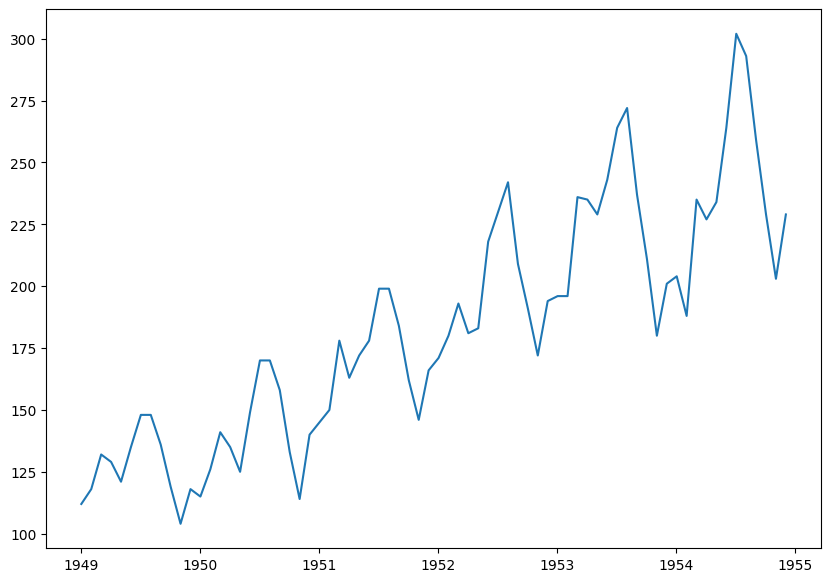

In [10]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['X_t'])
plt.show()

# 3. BoxCox

In [11]:
train['log_X_t'] = np.log(train['X_t'])
val['log_X_t'] = np.log(val['X_t'])
test['log_X_t'] = np.log(test['X_t'])

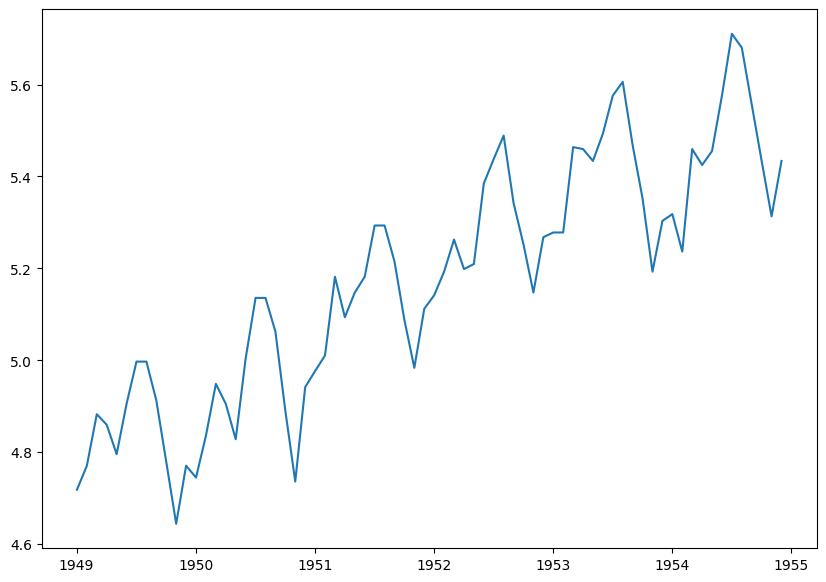

In [12]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_X_t'])
plt.show()

# 4. Exogen Regression

We dont have exogen variables.

# 5. Endogen Regression

We going to use linear trend. 

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
reg = LinearRegression().fit(train[['Time']], train['log_X_t'])

In [15]:
train['log_trend'] = reg.predict(train[['Time']])
val['log_trend'] = reg.predict(val[['Time']])
test['log_trend'] = reg.predict(test[['Time']])

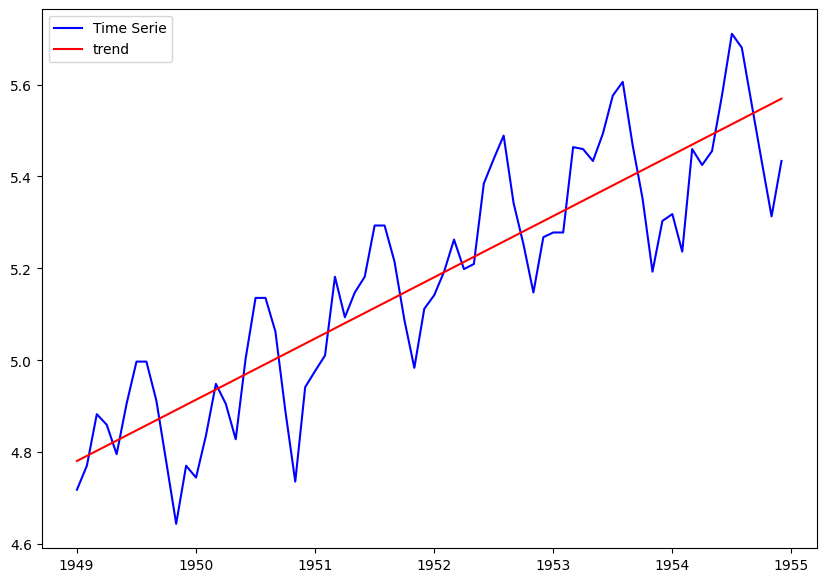

In [16]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_X_t'], color = 'blue', label = 'Time Serie')
plt.plot(train['Time'], train['log_trend'], color = 'red', label = 'trend')
plt.legend()
plt.show()

In [17]:
train['log_error'] = train['log_X_t'] - train['log_trend']
val['log_error'] = val['log_X_t'] - val['log_trend']
test['log_error'] = test['log_X_t'] - test['log_trend']

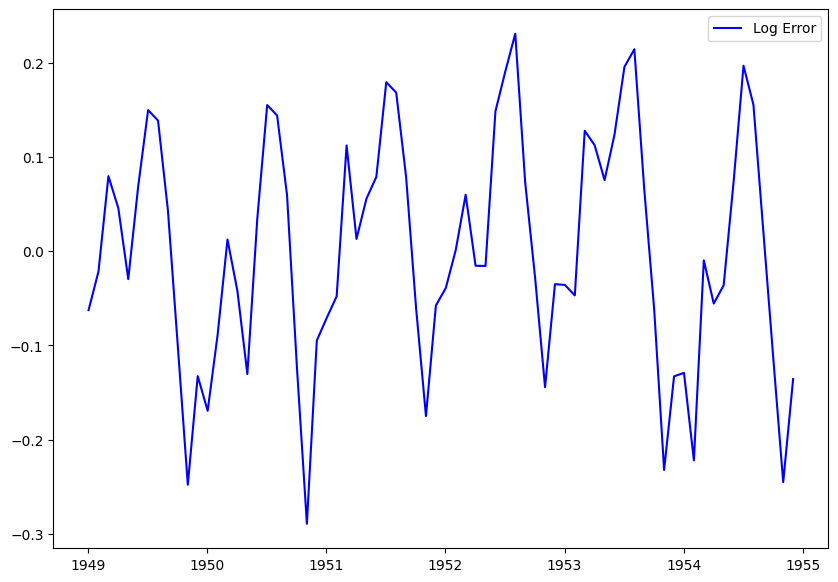

In [18]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_error'], color = 'blue', label = 'Log Error')
plt.legend()
plt.show()

# 6. ACF and PACF

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

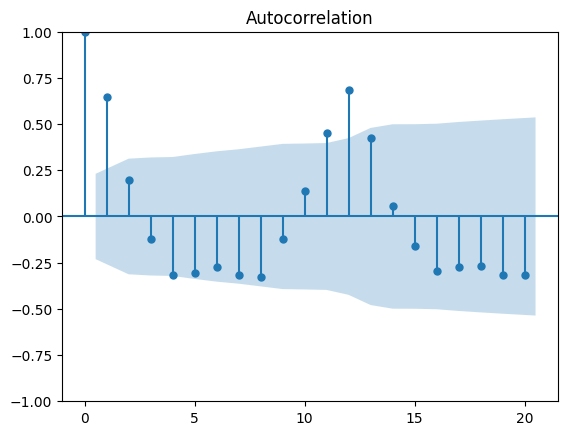

In [20]:
plot_acf(train['log_error'], lags = 20)
plt.show()

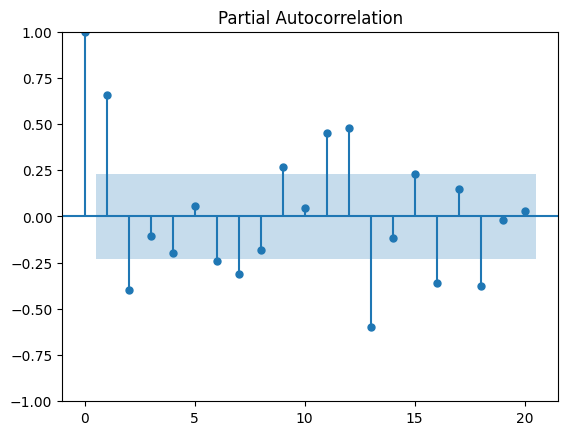

In [21]:
plot_pacf(train['log_error'], lags = 20)
plt.show()

# 7. New period

In [22]:
from scipy import signal

In [23]:
f, Pxx = signal.periodogram(train['log_error'])

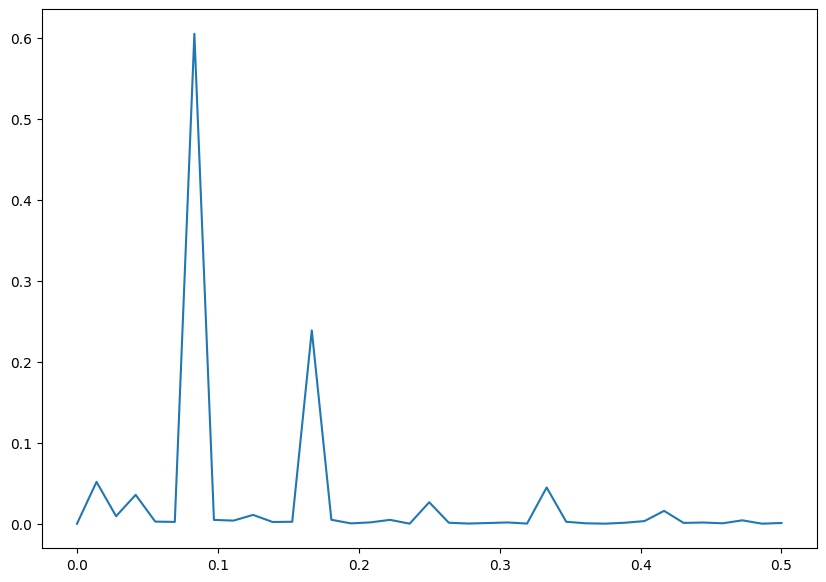

In [24]:
plt.figure(figsize = (10, 7))
plt.plot(f, Pxx)
plt.show()

In [25]:
T = 1/f[Pxx.argmax()]

In [26]:
T

12.0

# 8. Stationary

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
result_log_error = adfuller(train['log_error'].values)

In [29]:
print('ADF Statistic: %f' % result_log_error[0])
print('p-value: %f' % result_log_error[1])
print('Critical Values:')
for key, value in result_log_error[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.222274
p-value: 0.663941
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


**Comments:** Is not stationary.

# 9. Model Prophet

In [30]:
!pip install -q Prophet

In [31]:
from prophet import Prophet

In [32]:
train = train.rename(columns = {'log_error': 'y'})
val = val.rename(columns = {'log_error': 'y'})
test = test.rename(columns = {'log_error': 'y'})

In [33]:
model = Prophet()

In [34]:
model = model.fit(train[['ds', 'y']])

21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
train['log_error_predict'] = list(model.predict(train[['ds']])['yhat'])
val['log_error_predict'] = list(model.predict(val[['ds']])['yhat'])
test['log_error_predict'] = list(model.predict(test[['ds']])['yhat'])

In [36]:
train = train.rename(columns = {'y': 'log_error'})
val = val.rename(columns = {'y': 'log_error'})
test = test.rename(columns = {'y': 'log_error'})

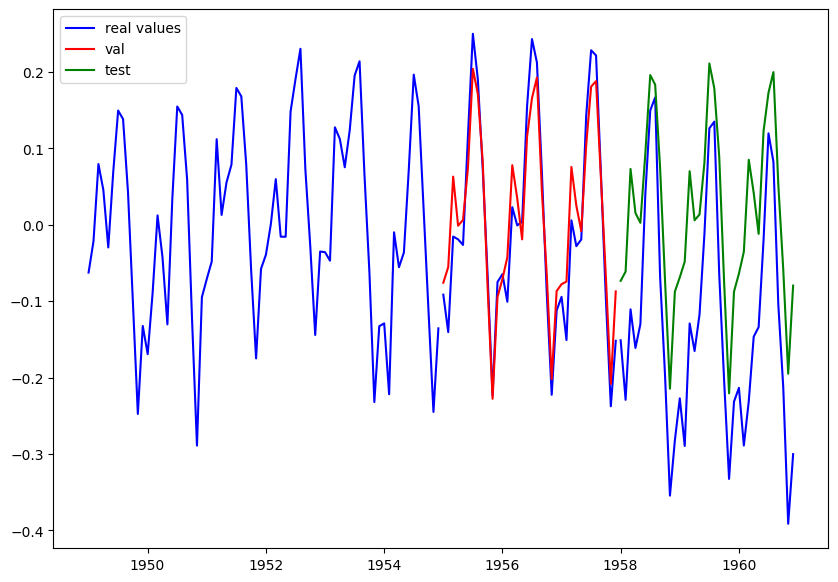

In [37]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_error'], color = 'blue', label = 'real values')

plt.plot(val['Time'], val['log_error'], color = 'blue')
plt.plot(test['Time'], test['log_error'], color = 'blue')

plt.plot(val['Time'], val['log_error_predict'], color = 'red', label = 'val')
plt.plot(test['Time'], test['log_error_predict'], color = 'green', label ='test')
plt.legend()
plt.show()

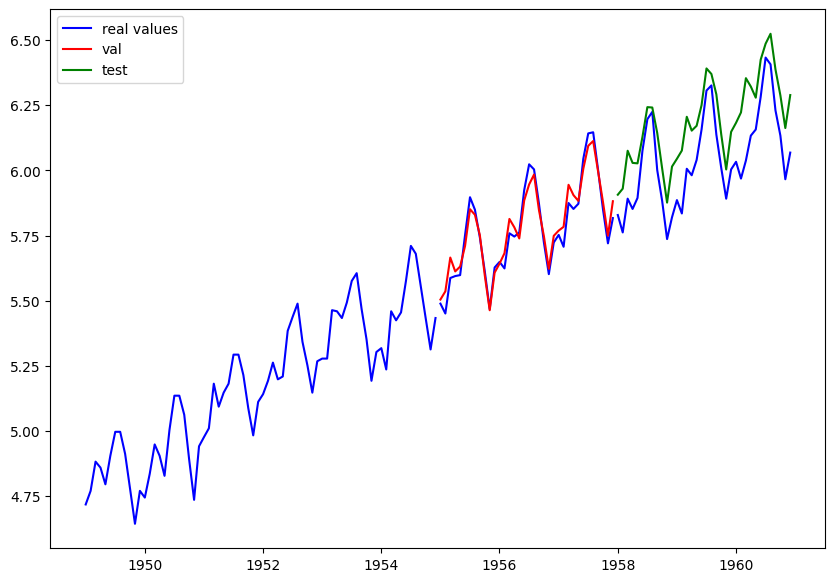

In [38]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_X_t'], color = 'blue', label = 'real values')

plt.plot(val['Time'], val['log_X_t'], color = 'blue')
plt.plot(test['Time'], test['log_X_t'], color = 'blue')

plt.plot(val['Time'], val['log_error_predict'] + val['log_trend'], color = 'red', label = 'val')
plt.plot(test['Time'], test['log_error_predict'] + test['log_trend'], color = 'green', label ='test')
plt.legend()
plt.show()

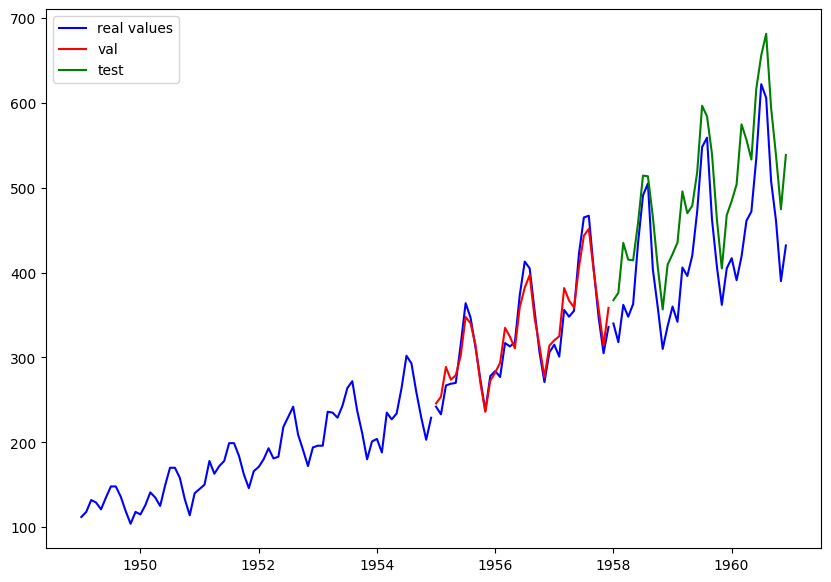

In [39]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['X_t'], color = 'blue', label = 'real values')

plt.plot(val['Time'], val['X_t'], color = 'blue')
plt.plot(test['Time'], test['X_t'], color = 'blue')

plt.plot(val['Time'], np.exp(val['log_error_predict'] + val['log_trend']), color = 'red', label = 'val')
plt.plot(test['Time'], np.exp(test['log_error_predict'] + test['log_trend']), color = 'green', label ='test')
plt.legend()
plt.show()

# 10. Performance Metrics

In [40]:
val['predict'] = np.exp(val['log_error_predict'] + val['log_trend'])
test['predict'] = np.exp(test['log_error_predict'] + test['log_trend'])

In [41]:
print('MSE val:', round(((val['predict'] - val['X_t'])**2).mean(), 2))
print('MAE val:', round((abs(val['predict'] - val['X_t'])).mean(), 2))
print('MAPE val:', round((abs(val['predict'] - val['X_t'])/val['X_t']).mean()*100, 2))

MSE val: 196.53
MAE val: 11.72
MAPE val: 3.57


In [42]:
print('MSE test:', round(((test['predict'] - test['X_t'])**2).mean(), 2))
print('MAE test:', round((abs(test['predict'] - test['X_t'])).mean(), 2))
print('MAPE test:', round((abs(test['predict'] - test['X_t'])/test['X_t']).mean()*100, 2))

MSE test: 5019.23
MAE test: 64.89
MAPE test: 15.73


# 11. Errors

In [43]:
val['error'] = val['X_t'] - val['predict']
test['error'] = test['X_t'] - test['predict']

### i. Normality

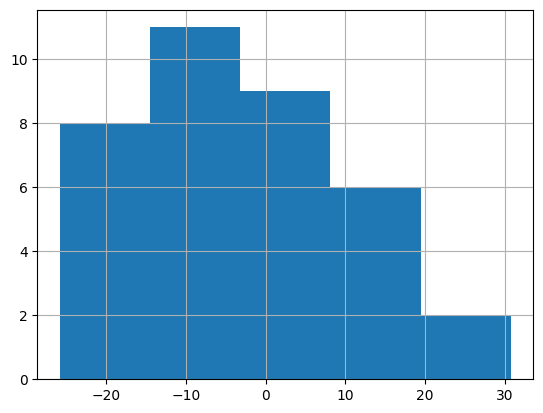

In [44]:
val['error'].hist(bins = 5)
plt.show()

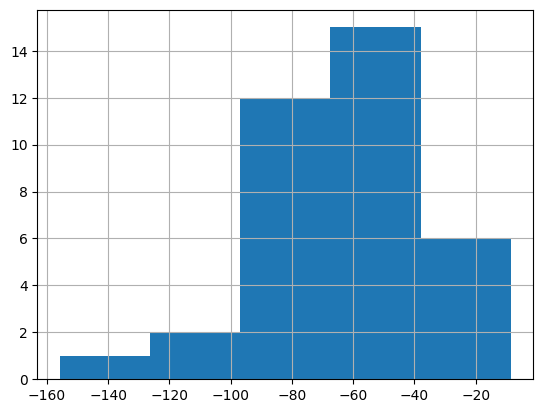

In [45]:
test['error'].hist(bins = 5)
plt.show()

**Comments:** We don't see the normality because with only the histogram is clearly that the errors isn't normals.

### ii. PACF and ACF

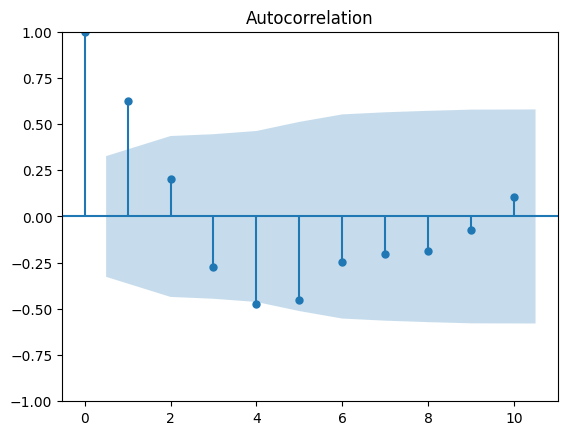

In [46]:
plot_acf(val['error'], lags = 10)
plt.show()

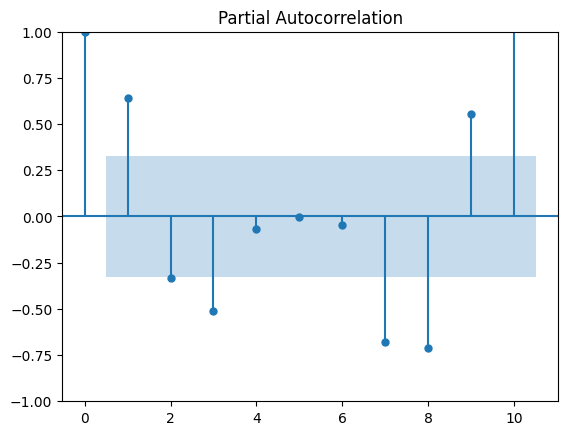

In [47]:
plot_pacf(val['error'], lags = 10)
plt.show()

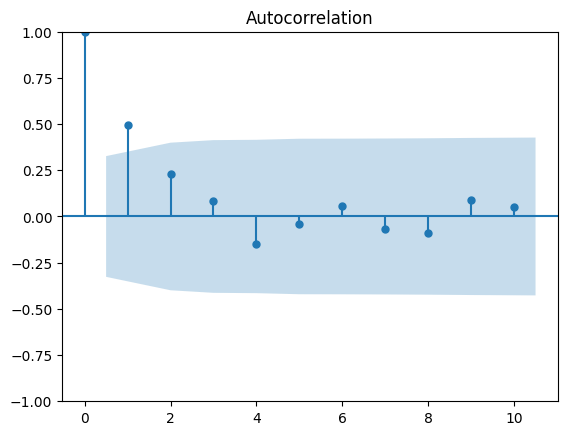

In [48]:
plot_acf(test['error'], lags = 10)
plt.show()

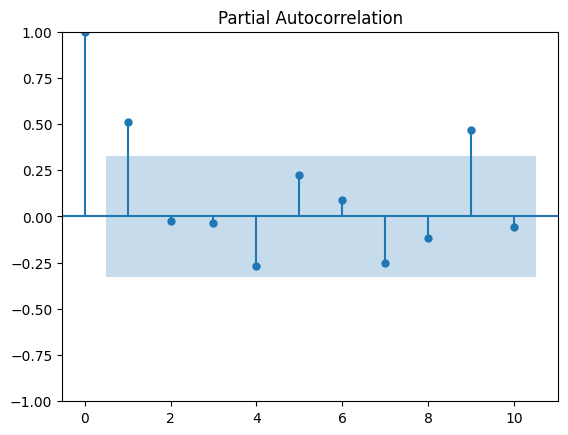

In [49]:
plot_pacf(test['error'], lags = 10)
plt.show()

### iii. Stationary

In [50]:
result_val = adfuller(val['error'].values)

In [51]:
print('ADF Statistic: %f' % result_val[0])
print('p-value: %f' % result_val[1])
print('Critical Values:')
for key, value in result_val[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.095617
p-value: 0.949873
Critical Values:
	1%: -3.711
	5%: -2.981
	10%: -2.630


**Comment:** Is stationary.

In [52]:
result_test = adfuller(test['error'].values)

In [53]:
print('ADF Statistic: %f' % result_test[0])
print('p-value: %f' % result_test[1])
print('Critical Values:')
for key, value in result_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.148768
p-value: 0.023148
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


**Comment:** Is stationary.

### Time of execution

In [54]:
end = time.time()

In [55]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 0 minutes and 4 seconds.
